In [1]:
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
import os

from dotenv import load_dotenv
load_dotenv()

print(_find_spark_home())

C:\Users\yan4etooo\anaconda3\envs\bigdata\Lib\site-packages\pyspark


In [2]:
python_path = os.environ.get('PYTHON_PATH')
app_name_nov = os.environ.get('APP_NAME_NOV')
hadoop_path_nov = os.environ.get('HADOOP_NOV_DATASET_PATH')

In [3]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark-local-dir', "C:\\spark-temp")\
    .set('spark.driver.memory', '4g')\
    .set('spark.executor.memory', '4g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', python_path)\
    .set('spark.pyspark.driver.python', python_path)\
    .set("spark.network.timeout","800s")\
    .set("spark.dynamicAllocation.enabled", "true")\
    .set("spark.shuffle.service.enabled", "true")\
    .set("spark.dynamicAllocation.minExecutors", "1")\
    .set("spark.dynamicAllocation.maxExecutors", "10")\
    .set("spark.dynamicAllocation.executorIdleTimeout", "60s")\

spark = SparkSession.builder.appName(app_name_nov).config(conf=conf).getOrCreate()
sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.dynamicAllocation.minExecutors', '1')
('spark.app.startTime', '1703671195684')
('spark.app.id', 'local-1703671199712')
('spark.shuffle.service.enabled', 'true')
('spark.driver.memory', '4g')
('spark.app.name', 'eCommerce')
('spark.executor.memory', '4g')
('spark.dynamicAllocation.maxExecutors', '10')
('spark.executor.id', 'driver')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.s

In [4]:
df = spark.read.csv(hadoop_path_nov+'/selected_Data/', header = True, inferSchema = True)
df.show()

+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|          id|event_type|product_id|     brand|  price|  user_id|   category|             product|day|
+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|403727064801|      view|   1004239|     apple|1413.16|554666475|electronics|          smartphone| 18|
| 42950433984|      view|   1004250|     apple| 741.04|527029321|electronics|          smartphone|  4|
| 34360364567|      view|   1004886|      oppo| 128.67|543083998|electronics|          smartphone|  4|
|360777911454|      view|   1480156|       neo| 666.66|519293476|  computers|             desktop| 17|
| 85900085278|      view|   6400162|     intel| 215.58|533512255|  computers|      components.cpu|  7|
|180389410990|      view|   1201284|    lenovo| 154.19|570911983|electronics|              tablet| 13|
| 17180281985|      view|   3900339|      aqua|  30.86|517565940| applian

### Question:
How many times did the customer view the product before purchasing it?

In [5]:
# Apply filter early and select only necessary columns
views_df = df.filter(df.event_type == 'view').select('user_id', 'product_id', 'day').withColumnRenamed('day', 'day_view')
purchases_df = df.filter(df.event_type == 'purchase').select('user_id', 'product_id', 'day', 'product', 'category', 'brand', 'price').withColumnRenamed('day', 'day_purchase')

# Join on user_id and product_id (using regular join here)
joined_df = views_df.join(purchases_df, ['user_id', 'product_id'], 'inner')

# Cache joined_df if it will be used multiple times
# joined_df.cache()

# Ensure views are before purchase and filter
valid_views_df = joined_df.filter(joined_df.day_view <= joined_df.day_purchase)

# Group and aggregate
final_df = valid_views_df.groupBy('user_id', 'product_id', 'product', 'category', 'brand', 'price') \
                         .agg(F.count('day_view').alias('views_before_purchase'))

# Show the final DataFrame
final_df.show()

+---------+----------+--------------------+-----------+--------+------+---------------------+
|  user_id|product_id|             product|   category|   brand| price|views_before_purchase|
+---------+----------+--------------------+-----------+--------+------+---------------------+
|307138432|   1004904|          smartphone|electronics|  huawei|106.57|                    1|
|315835135|  17800444|             desktop|  computers| dxracer|334.37|                    4|
|369801696|   1005115|          smartphone|electronics|   apple|914.43|                    1|
|404851685|   5800605|     audio.subwoofer|electronics|   focal|  48.5|                    2|
|439209037|   7003777|            carriage|       kids|    anex|790.24|                    7|
|442687924|   1005099|          smartphone|electronics| samsung|136.66|                    1|
|445339240|   6701017|components.videoc...|  computers|gigabyte|277.74|                    3|
|456056600|   1005121|          smartphone|electronics|   ap

In [6]:
# Order final_df by views_before_purchase in descending order
sorted_final_df = final_df.orderBy(F.desc('views_before_purchase'))

# Show the sorted DataFrame
sorted_final_df.show()

+---------+----------+--------------------+-----------+-------+-------+---------------------+
|  user_id|product_id|             product|   category|  brand|  price|views_before_purchase|
+---------+----------+--------------------+-----------+-------+-------+---------------------+
|518514099|   1005116|          smartphone|electronics|  apple|1013.85|                13031|
|549385752|   4804056|     audio.headphone|electronics|  apple| 167.06|                11415|
|566195962|   1801723|            video.tv|electronics|    tcl| 149.29|                 9545|
|543128872|   4804056|     audio.headphone|electronics|  apple| 161.63|                 8004|
|564068124|   1004833|          smartphone|electronics|samsung| 170.05|                 5229|
|541385001|   1005113|          smartphone|electronics|  apple|1052.28|                 4808|
|543128872|   4804056|     audio.headphone|electronics|  apple|  162.6|                 4012|
|543128872|   4804056|     audio.headphone|electronics|  app

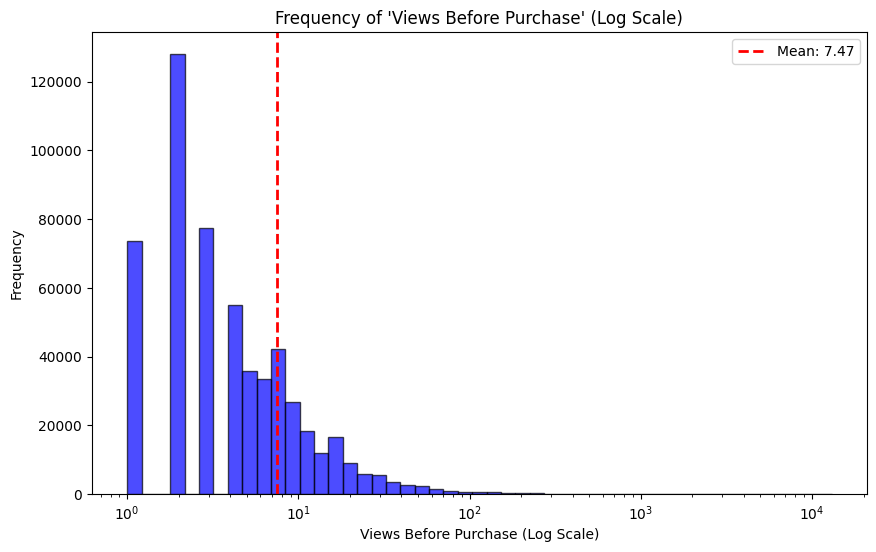

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the specific column to Pandas for visualization
views_before_purchase_pd = final_df.select('views_before_purchase').toPandas()

# Create a histogram for the views
plt.figure(figsize=(10, 6))
plt.hist(views_before_purchase_pd['views_before_purchase'], bins=np.logspace(np.log10(1), np.log10(views_before_purchase_pd['views_before_purchase'].max()), 50), alpha=0.7, color='blue', edgecolor='black')
plt.gca().set_xscale("log")

# Calculate and show mean
mean_value = views_before_purchase_pd['views_before_purchase'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

title = "Frequency of 'Views Before Purchase' (Log Scale)"
plt.title(title)
plt.xlabel('Views Before Purchase (Log Scale)')
plt.ylabel('Frequency')
plt.legend()

plt.show()


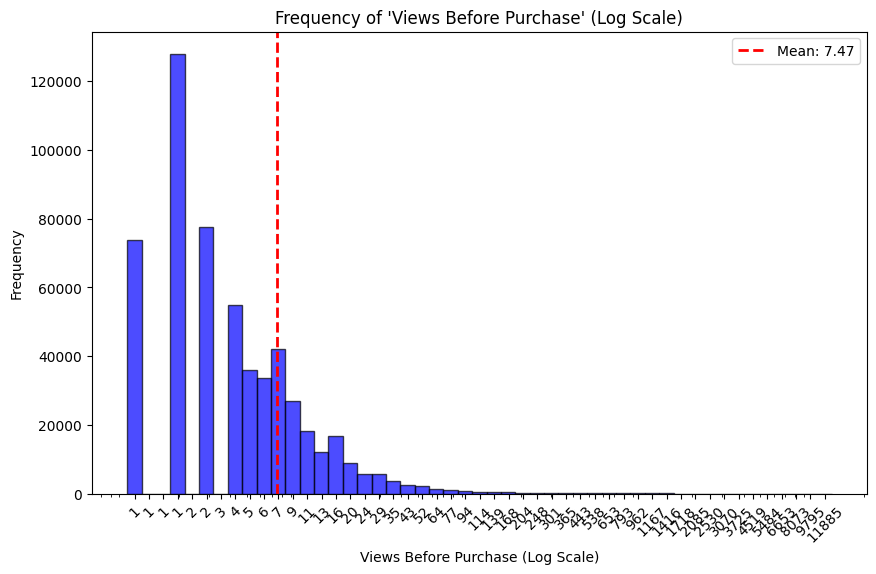

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_df is your Spark DataFrame with the 'views_before_purchase' column

# Convert the specific column to Pandas for visualization
views_before_purchase_pd = final_df.select('views_before_purchase').toPandas()

# Create a histogram with logarithmic bins
plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(views_before_purchase_pd['views_before_purchase'], bins=np.logspace(np.log10(1), np.log10(views_before_purchase_pd['views_before_purchase'].max()), 50), alpha=0.7, color='blue', edgecolor='black')
plt.gca().set_xscale("log")

# Set custom tick marks and labels on the x-axis
tick_locs = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]  # Midpoint of each bin
plt.xticks(tick_locs, labels=[f"{int(x)}" for x in tick_locs], rotation=45)

# Calculate and show mean
mean_value = views_before_purchase_pd['views_before_purchase'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

title = "Frequency of 'Views Before Purchase' (Log Scale)"
plt.title(title)
plt.xlabel('Views Before Purchase (Log Scale)')
plt.ylabel('Frequency')
plt.legend()

plt.show()
